# About

This notebook contains basic experiments using different datasets, mostly combining them. I used bag of words to convert abstracts to vectors.

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
ROOT_PATH = "/content/drive/My Drive/Magíster 2020"

In [ ]:
vocab_size = 10000
embedding_dim = 512
max_length = 1000
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = 1
num_epochs = 10

## Train PUC / Test PUC

In [ ]:
puc_train = pd.read_json(f"{ROOT_PATH}/Ordenado/new_train_test_data/puc_train_70.json", orient="records")
puc_test = pd.read_json(f"{ROOT_PATH}/Ordenado/new_train_test_data/puc_test_30.json", orient="records")

In [ ]:
puc_train["len"] = puc_train["clean_abstract"].str.split().str.len()

In [ ]:
puc_train["len"].describe()

count    923.000000
mean     206.679307
std       84.825680
min       32.000000
25%      152.000000
50%      201.000000
75%      249.000000
max      938.000000
Name: len, dtype: float64

In [ ]:
tokenizer_abstracts = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_abstracts.fit_on_texts(puc_train["clean_abstract"])

train_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(puc_train["clean_abstract"])
train_padded_abstracts = pad_sequences(train_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(puc_test["clean_abstract"])
test_padded_abstracts = pad_sequences(test_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
tokenizer_titles = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_titles.fit_on_texts(puc_train["title"])

train_sequences_titles = tokenizer_titles.texts_to_sequences(puc_train["title"])
train_padded_titles = pad_sequences(train_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences_titles = tokenizer_titles.texts_to_sequences(puc_test["title"])
test_padded_titles = pad_sequences(test_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
abstracts_input = tf.keras.layers.Input(shape=[max_length])
x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(abstracts_input)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))(x)
x = tf.keras.Model(inputs=abstracts_input, outputs=x)

In [ ]:
titles_input = tf.keras.layers.Input(shape=[max_length])
y = tf.keras.layers.Embedding(vocab_size, embedding_dim)(titles_input)
y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))(y)
y = tf.keras.Model(inputs=titles_input, outputs=y)

In [ ]:
combined = tf.keras.layers.concatenate([x.output, y.output])

In [ ]:
z = tf.keras.layers.Dense(embedding_dim, activation='relu')(combined)
z = tf.keras.layers.Dense(18, activation='softmax')(z)

In [ ]:
model = tf.keras.Model(inputs=[x.input, y.input], outputs=z)

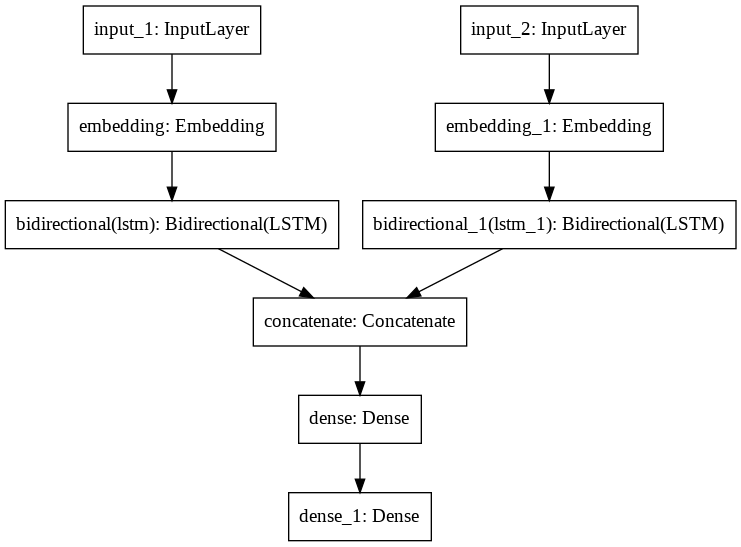

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit([train_padded_abstracts, train_padded_titles], puc_train["first_sdg"], epochs=num_epochs, validation_data=([test_padded_abstracts, test_padded_titles], puc_test["first_sdg"]), verbose=1)

Epoch 1/10
29/29 [==============================] - 15s 525ms/step - loss: 2.1798 - accuracy: 0.4561 - val_loss: 1.9684 - val_accuracy: 0.4569
Epoch 2/10
29/29 [==============================] - 14s 481ms/step - loss: 1.6947 - accuracy: 0.5016 - val_loss: 1.8651 - val_accuracy: 0.4442
Epoch 3/10
29/29 [==============================] - 14s 481ms/step - loss: 1.2172 - accuracy: 0.6425 - val_loss: 1.4934 - val_accuracy: 0.5964
Epoch 4/10
29/29 [==============================] - 14s 485ms/step - loss: 0.6255 - accuracy: 0.8104 - val_loss: 1.8237 - val_accuracy: 0.5533
Epoch 5/10
29/29 [==============================] - 14s 483ms/step - loss: 0.2728 - accuracy: 0.9133 - val_loss: 1.8427 - val_accuracy: 0.5508
Epoch 6/10
29/29 [==============================] - 14s 482ms/step - loss: 0.1210 - accuracy: 0.9653 - val_loss: 2.3121 - val_accuracy: 0.5127
Epoch 7/10
29/29 [==============================] - 14s 485ms/step - loss: 0.0379 - accuracy: 0.9913 - val_loss: 2.3936 - val_accuracy: 0.5228

In [ ]:
predictions = np.argmax(model.predict([test_padded_abstracts, test_padded_titles]), axis=-1)

In [ ]:
print(classification_report(puc_test["first_sdg"], predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.21      0.33      0.26        15
           3       0.78      0.86      0.82       180
           4       0.71      0.50      0.59        30
           5       0.00      0.00      0.00         2
           6       0.67      0.18      0.29        11
           7       0.43      0.27      0.33        11
           8       0.00      0.00      0.00         5
           9       0.28      0.29      0.28        28
          10       0.25      0.14      0.18         7
          11       0.50      0.38      0.43        32
          12       0.00      0.00      0.00         8
          13       0.14      0.10      0.12        10
          14       0.36      0.31      0.33        13
          15       0.50      0.28      0.36        25
          16       0.12      0.17      0.14        12
          17       0.00      0.00      0.00         3

    accuracy              

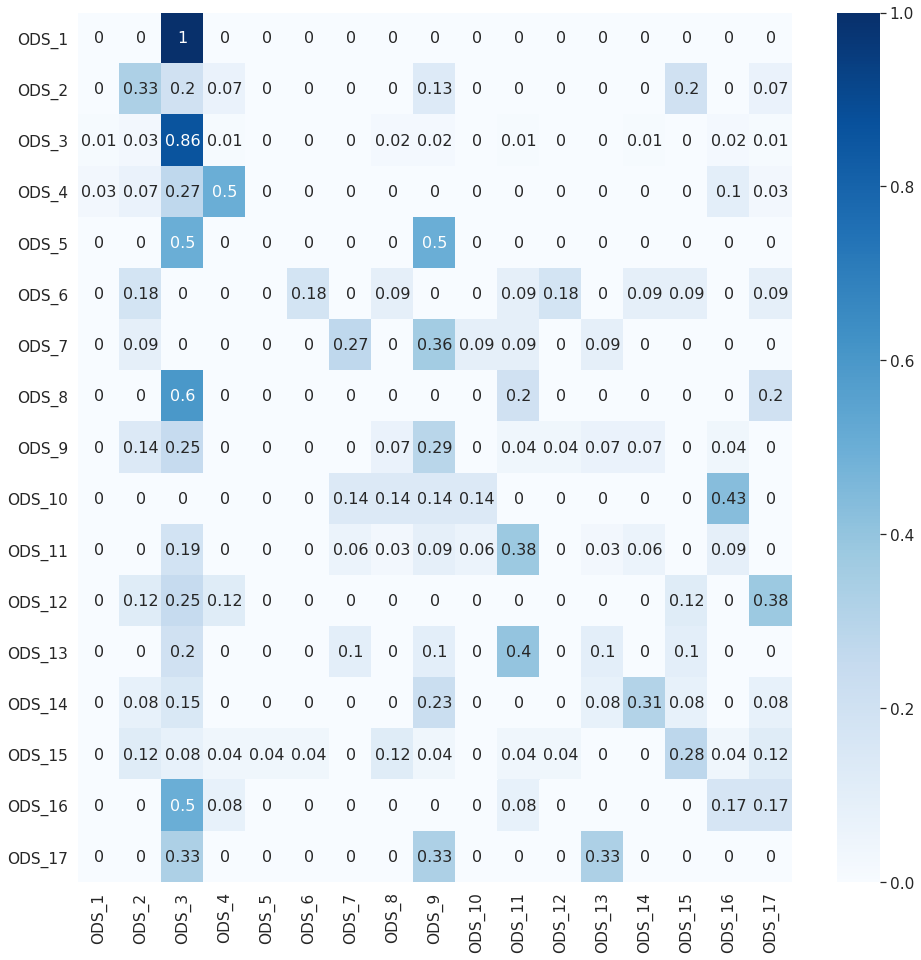

In [ ]:
conf_matrix = confusion_matrix(puc_test["first_sdg"], predictions, labels=range(1, 18), normalize="true")
sdg_index = [f"ODS_{i}" for i in range(1, 18)]
df_cm = pd.DataFrame(conf_matrix, columns=sdg_index, index=sdg_index)
df_cm = df_cm.round(2)
plt.figure(figsize=(16,16))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt="g")
plt.show()

## Train PUC (train PUC only) / Test PUJ

In [ ]:
puj_train = pd.read_json(f"{ROOT_PATH}/Ordenado/new_train_test_data/puj_train_70.json", orient="records")
puj_test = pd.read_json(f"{ROOT_PATH}/Ordenado/new_train_test_data/puj_test_30.json", orient="records")

In [ ]:
tokenizer_abstracts = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_abstracts.fit_on_texts(puc_train["clean_abstract"])

test_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(puj_test["clean_abstract"])
test_padded_abstracts = pad_sequences(test_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
tokenizer_titles = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_titles.fit_on_texts(puc_train["title"])

test_sequences_titles = tokenizer_titles.texts_to_sequences(puj_test["title"])
test_padded_titles = pad_sequences(test_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
predictions = np.argmax(model.predict([test_padded_abstracts, test_padded_titles]), axis=-1)

In [ ]:
print(classification_report(puj_test["first_sdg"], predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         8
           3       0.76      0.81      0.79        86
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1
           6       1.00      0.14      0.25         7
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       0.10      0.12      0.11         8
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         3

    accuracy              

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Train PUC (concat train PUC + test PUC) / Test PUJ

In [ ]:
puc = pd.concat([puc_train, puc_test], ignore_index=True)

In [ ]:
tokenizer_abstracts = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_abstracts.fit_on_texts(puc["clean_abstract"])

train_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(puc["clean_abstract"])
train_padded_abstracts = pad_sequences(train_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(puj_test["clean_abstract"])
test_padded_abstracts = pad_sequences(test_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
tokenizer_titles = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_titles.fit_on_texts(puc_train["title"])

train_sequences_titles = tokenizer_titles.texts_to_sequences(puc["title"])
train_padded_titles = pad_sequences(train_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences_titles = tokenizer_titles.texts_to_sequences(puj_test["title"])
test_padded_titles = pad_sequences(test_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
abstracts_input = tf.keras.layers.Input(shape=[max_length])
x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(abstracts_input)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))(x)
x = tf.keras.Model(inputs=abstracts_input, outputs=x)

In [ ]:
titles_input = tf.keras.layers.Input(shape=[max_length])
y = tf.keras.layers.Embedding(vocab_size, embedding_dim)(titles_input)
y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))(y)
y = tf.keras.Model(inputs=titles_input, outputs=y)

In [ ]:
combined = tf.keras.layers.concatenate([x.output, y.output])

In [ ]:
z = tf.keras.layers.Dense(embedding_dim, activation='relu')(combined)
z = tf.keras.layers.Dense(18, activation='softmax')(z)

In [ ]:
model = tf.keras.Model(inputs=[x.input, y.input], outputs=z)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit([train_padded_abstracts, train_padded_titles], puc["first_sdg"], epochs=num_epochs, validation_data=([test_padded_abstracts, test_padded_titles], puj_test["first_sdg"]), verbose=1)

Epoch 1/10
42/42 [==============================] - 19s 460ms/step - loss: 2.1123 - accuracy: 0.4495 - val_loss: 1.8257 - val_accuracy: 0.6000
Epoch 2/10
42/42 [==============================] - 18s 435ms/step - loss: 1.5849 - accuracy: 0.5406 - val_loss: 2.1053 - val_accuracy: 0.5071
Epoch 3/10
42/42 [==============================] - 18s 436ms/step - loss: 1.0139 - accuracy: 0.6955 - val_loss: 2.4691 - val_accuracy: 0.5000
Epoch 4/10
42/42 [==============================] - 18s 438ms/step - loss: 0.4600 - accuracy: 0.8504 - val_loss: 3.0877 - val_accuracy: 0.5000
Epoch 5/10
42/42 [==============================] - 18s 435ms/step - loss: 0.2368 - accuracy: 0.9233 - val_loss: 3.0740 - val_accuracy: 0.4500
Epoch 6/10
42/42 [==============================] - 19s 442ms/step - loss: 0.1053 - accuracy: 0.9696 - val_loss: 3.6109 - val_accuracy: 0.4214
Epoch 7/10
42/42 [==============================] - 18s 434ms/step - loss: 0.0432 - accuracy: 0.9916 - val_loss: 3.8111 - val_accuracy: 0.4286

In [ ]:
predictions = np.argmax(model.predict([test_padded_abstracts, test_padded_titles]), axis=-1)

In [ ]:
print(classification_report(puj_test["first_sdg"], predictions))

              precision    recall  f1-score   support

           1       0.12      0.22      0.16         9
           2       0.00      0.00      0.00         8
           3       0.78      0.72      0.75        86
           4       1.00      0.33      0.50         3
           5       0.00      0.00      0.00         1
           6       1.00      0.29      0.44         7
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         0
          15       0.14      0.50      0.22         2
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         3

    accuracy              

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


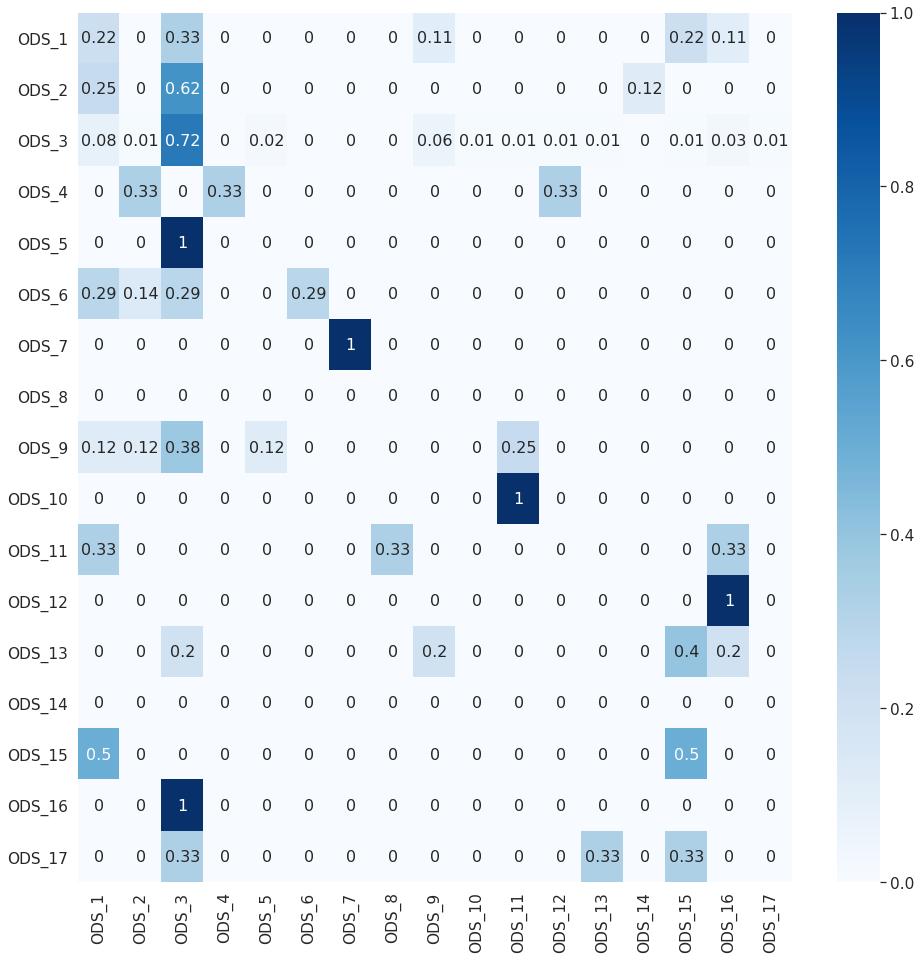

In [ ]:
conf_matrix = confusion_matrix(puj_test["first_sdg"], predictions, labels=range(1, 18), normalize="true")
sdg_index = [f"ODS_{i}" for i in range(1, 18)]
df_cm = pd.DataFrame(conf_matrix, columns=sdg_index, index=sdg_index)
df_cm = df_cm.round(2)
plt.figure(figsize=(16,16))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt="g")
plt.show()

## Train PUC + PUJ / Test PUC + PUJ

In [ ]:
train = pd.concat([puc_train, puj_train], ignore_index=True)
test = pd.concat([puc_test, puj_test], ignore_index=True)

In [ ]:
tokenizer_abstracts = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_abstracts.fit_on_texts(train["clean_abstract"])

train_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(train["clean_abstract"])
train_padded_abstracts = pad_sequences(train_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(test["clean_abstract"])
test_padded_abstracts = pad_sequences(test_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
tokenizer_titles = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_titles.fit_on_texts(train["title"])

train_sequences_titles = tokenizer_titles.texts_to_sequences(train["title"])
train_padded_titles = pad_sequences(train_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences_titles = tokenizer_titles.texts_to_sequences(test["title"])
test_padded_titles = pad_sequences(test_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
abstracts_input = tf.keras.layers.Input(shape=[max_length])
x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(abstracts_input)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))(x)
x = tf.keras.Model(inputs=abstracts_input, outputs=x)

In [ ]:
titles_input = tf.keras.layers.Input(shape=[max_length])
y = tf.keras.layers.Embedding(vocab_size, embedding_dim)(titles_input)
y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))(y)
y = tf.keras.Model(inputs=titles_input, outputs=y)

In [ ]:
combined = tf.keras.layers.concatenate([x.output, y.output])

In [ ]:
z = tf.keras.layers.Dense(embedding_dim, activation='relu')(combined)
z = tf.keras.layers.Dense(18, activation='softmax')(z)

In [ ]:
model = tf.keras.Model(inputs=[x.input, y.input], outputs=z)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit([train_padded_abstracts, train_padded_titles], train["first_sdg"], epochs=num_epochs, validation_data=([test_padded_abstracts, test_padded_titles], test["first_sdg"]), verbose=1)

Epoch 1/10
40/40 [==============================] - 21s 514ms/step - loss: 2.1718 - accuracy: 0.4960 - val_loss: 1.8161 - val_accuracy: 0.4981
Epoch 2/10
40/40 [==============================] - 19s 486ms/step - loss: 1.5693 - accuracy: 0.5536 - val_loss: 1.7203 - val_accuracy: 0.5318
Epoch 3/10
40/40 [==============================] - 20s 488ms/step - loss: 1.1303 - accuracy: 0.6608 - val_loss: 1.7559 - val_accuracy: 0.5300
Epoch 4/10
40/40 [==============================] - 19s 486ms/step - loss: 0.5758 - accuracy: 0.8224 - val_loss: 1.9771 - val_accuracy: 0.5169
Epoch 5/10
40/40 [==============================] - 19s 486ms/step - loss: 0.2548 - accuracy: 0.9224 - val_loss: 2.4634 - val_accuracy: 0.5506
Epoch 6/10
40/40 [==============================] - 19s 486ms/step - loss: 0.1346 - accuracy: 0.9664 - val_loss: 2.5538 - val_accuracy: 0.4457
Epoch 7/10
40/40 [==============================] - 19s 487ms/step - loss: 0.0674 - accuracy: 0.9824 - val_loss: 2.5549 - val_accuracy: 0.5075

In [ ]:
predictions = np.argmax(model.predict([test_padded_abstracts, test_padded_titles]), axis=-1)

In [ ]:
print(classification_report(test["first_sdg"], predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        11
           2       0.07      0.09      0.08        23
           3       0.79      0.87      0.82       266
           4       0.43      0.39      0.41        33
           5       0.00      0.00      0.00         3
           6       0.46      0.33      0.39        18
           7       0.33      0.17      0.22        12
           8       0.00      0.00      0.00         5
           9       0.27      0.22      0.24        36
          10       0.00      0.00      0.00         8
          11       0.44      0.31      0.37        35
          12       0.00      0.00      0.00        10
          13       0.09      0.13      0.11        15
          14       0.25      0.15      0.19        13
          15       0.38      0.30      0.33        27
          16       0.13      0.15      0.14        13
          17       0.05      0.33      0.09         6

    accuracy              

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


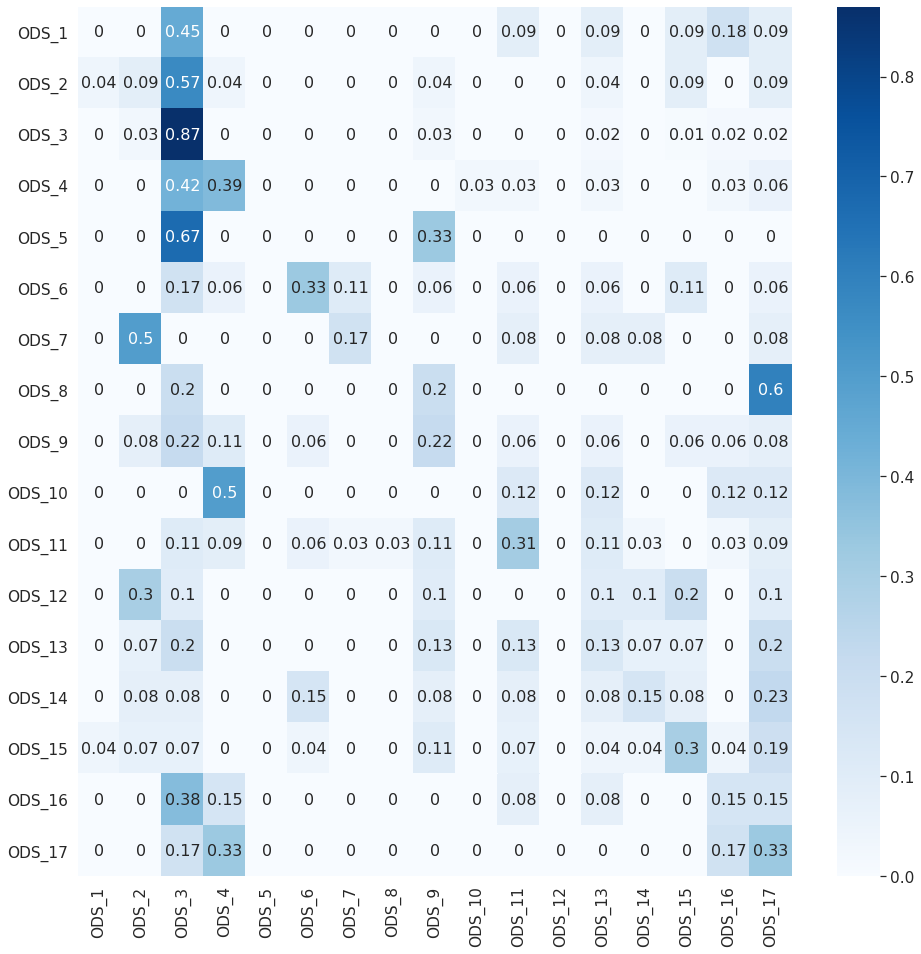

In [ ]:
conf_matrix = confusion_matrix(test["first_sdg"], predictions, labels=range(1, 18), normalize="true")
sdg_index = [f"ODS_{i}" for i in range(1, 18)]
df_cm = pd.DataFrame(conf_matrix, columns=sdg_index, index=sdg_index)
df_cm = df_cm.round(2)
plt.figure(figsize=(16,16))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt="g")
plt.show()

**We don't use PUJ as training set alone because there are too few examples**

## Train Aurora / Test Aurora

In [ ]:
aurora_train = pd.read_json(f"{ROOT_PATH}/Ordenado/new_train_test_data/aurora_train_70.json", orient="records")
aurora_test = pd.read_json(f"{ROOT_PATH}/Ordenado/new_train_test_data/aurora_test_30.json", orient="records")

In [ ]:
tokenizer_abstracts = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_abstracts.fit_on_texts(aurora_train["clean_abstract"])

train_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(aurora_train["clean_abstract"])
train_padded_abstracts = pad_sequences(train_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(aurora_test["clean_abstract"])
test_padded_abstracts = pad_sequences(test_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
tokenizer_titles = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_titles.fit_on_texts(aurora_train["title"])

train_sequences_titles = tokenizer_titles.texts_to_sequences(aurora_train["title"])
train_padded_titles = pad_sequences(train_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences_titles = tokenizer_titles.texts_to_sequences(aurora_test["title"])
test_padded_titles = pad_sequences(test_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
abstracts_input = tf.keras.layers.Input(shape=[max_length])
x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(abstracts_input)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))(x)
x = tf.keras.Model(inputs=abstracts_input, outputs=x)

In [ ]:
titles_input = tf.keras.layers.Input(shape=[max_length])
y = tf.keras.layers.Embedding(vocab_size, embedding_dim)(titles_input)
y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))(y)
y = tf.keras.Model(inputs=titles_input, outputs=y)

In [ ]:
combined = tf.keras.layers.concatenate([x.output, y.output])

In [ ]:
z = tf.keras.layers.Dense(embedding_dim, activation='relu')(combined)
z = tf.keras.layers.Dense(18, activation='softmax')(z)

In [ ]:
model = tf.keras.Model(inputs=[x.input, y.input], outputs=z)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit([train_padded_abstracts, train_padded_titles], aurora_train["first_sdg"], epochs=num_epochs, validation_data=([test_padded_abstracts, test_padded_titles], aurora_test["first_sdg"]), verbose=1)

Epoch 1/10
133/133 [==============================] - 67s 504ms/step - loss: 2.1554 - accuracy: 0.3473 - val_loss: 1.6966 - val_accuracy: 0.4536
Epoch 2/10
133/133 [==============================] - 66s 495ms/step - loss: 1.2327 - accuracy: 0.5950 - val_loss: 1.6437 - val_accuracy: 0.5127
Epoch 3/10
133/133 [==============================] - 66s 495ms/step - loss: 0.5581 - accuracy: 0.8233 - val_loss: 1.8796 - val_accuracy: 0.4972
Epoch 4/10
133/133 [==============================] - 66s 496ms/step - loss: 0.1688 - accuracy: 0.9493 - val_loss: 2.3748 - val_accuracy: 0.5028
Epoch 5/10
133/133 [==============================] - 66s 493ms/step - loss: 0.0709 - accuracy: 0.9797 - val_loss: 2.6664 - val_accuracy: 0.5210
Epoch 6/10
133/133 [==============================] - 66s 495ms/step - loss: 0.0202 - accuracy: 0.9953 - val_loss: 2.9412 - val_accuracy: 0.5116
Epoch 7/10
133/133 [==============================] - 66s 494ms/step - loss: 0.0181 - accuracy: 0.9953 - val_loss: 3.0722 - val_ac

In [ ]:
predictions = np.argmax(model.predict([test_padded_abstracts, test_padded_titles]), axis=-1)

In [ ]:
print(classification_report(aurora_test["first_sdg"], predictions))

              precision    recall  f1-score   support

           1       0.11      0.50      0.18         2
           2       0.19      0.15      0.17        48
           3       0.80      0.78      0.79       505
           4       0.70      0.52      0.60       168
           5       0.50      0.47      0.49       119
           6       0.38      0.55      0.45        73
           7       0.54      0.40      0.46        97
           8       0.67      0.07      0.13        27
           9       0.27      0.06      0.10       100
          10       0.26      0.17      0.20        71
          11       0.45      0.35      0.40       102
          12       0.27      0.38      0.31        96
          13       0.24      0.35      0.29       101
          14       0.17      0.43      0.25        46
          15       0.30      0.49      0.37       122
          16       0.44      0.44      0.44        96
          17       0.12      0.05      0.07        39

    accuracy              

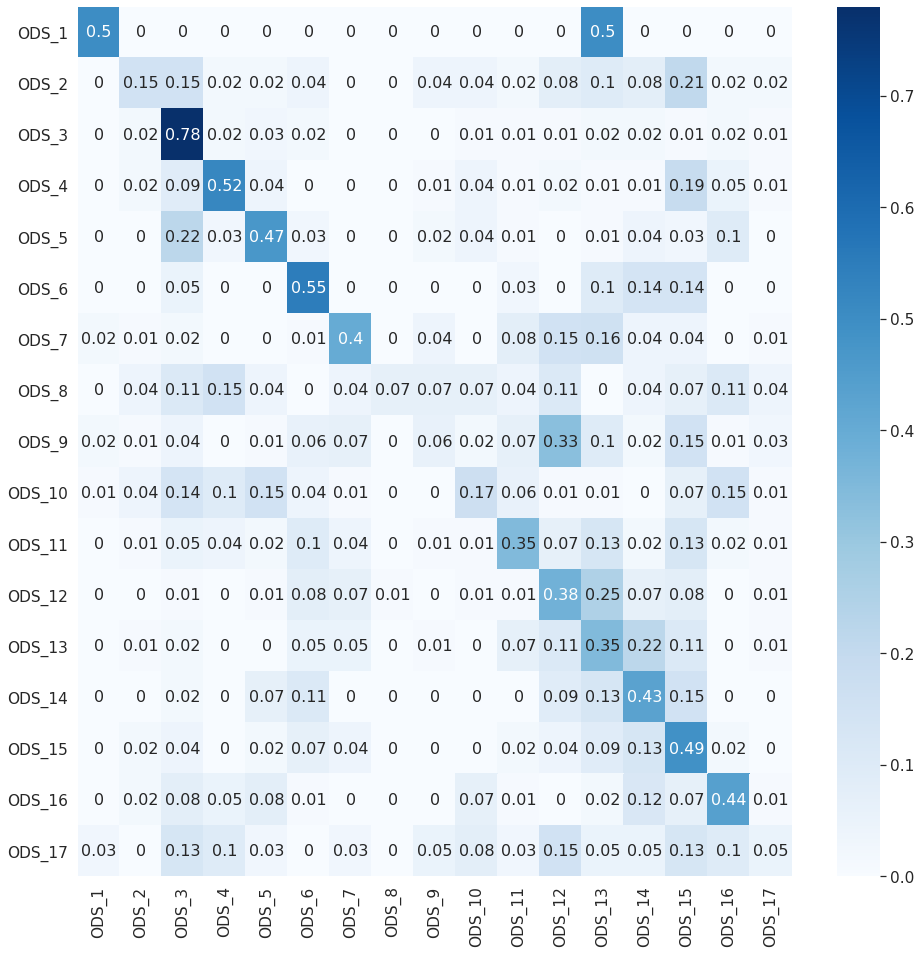

In [ ]:
conf_matrix = confusion_matrix(aurora_test["first_sdg"], predictions, labels=range(1, 18), normalize="true")
sdg_index = [f"ODS_{i}" for i in range(1, 18)]
df_cm = pd.DataFrame(conf_matrix, columns=sdg_index, index=sdg_index)
df_cm = df_cm.round(2)
plt.figure(figsize=(16,16))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt="g")
plt.show()

## Train Aurora / Test PUC

In [ ]:
tokenizer_abstracts = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_abstracts.fit_on_texts(aurora_train["clean_abstract"])

test_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(puc_test["clean_abstract"])
test_padded_abstracts = pad_sequences(test_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
tokenizer_titles = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_titles.fit_on_texts(aurora_train["title"])

test_sequences_titles = tokenizer_titles.texts_to_sequences(puc_test["title"])
test_padded_titles = pad_sequences(test_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
predictions = np.argmax(model.predict([test_padded_abstracts, test_padded_titles]), axis=-1)


In [ ]:
print(classification_report(puc_test["first_sdg"], predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.05      0.07      0.06        15
           3       0.90      0.61      0.73       180
           4       0.46      0.40      0.43        30
           5       0.00      0.00      0.00         2
           6       0.25      0.55      0.34        11
           7       0.50      0.36      0.42        11
           8       1.00      0.20      0.33         5
           9       0.00      0.00      0.00        28
          10       0.17      0.14      0.15         7
          11       0.50      0.38      0.43        32
          12       0.09      0.12      0.11         8
          13       0.17      0.40      0.24        10
          14       0.11      0.31      0.16        13
          15       0.20      0.36      0.26        25
          16       0.16      0.25      0.19        12
          17       0.00      0.00      0.00         3

    accuracy              

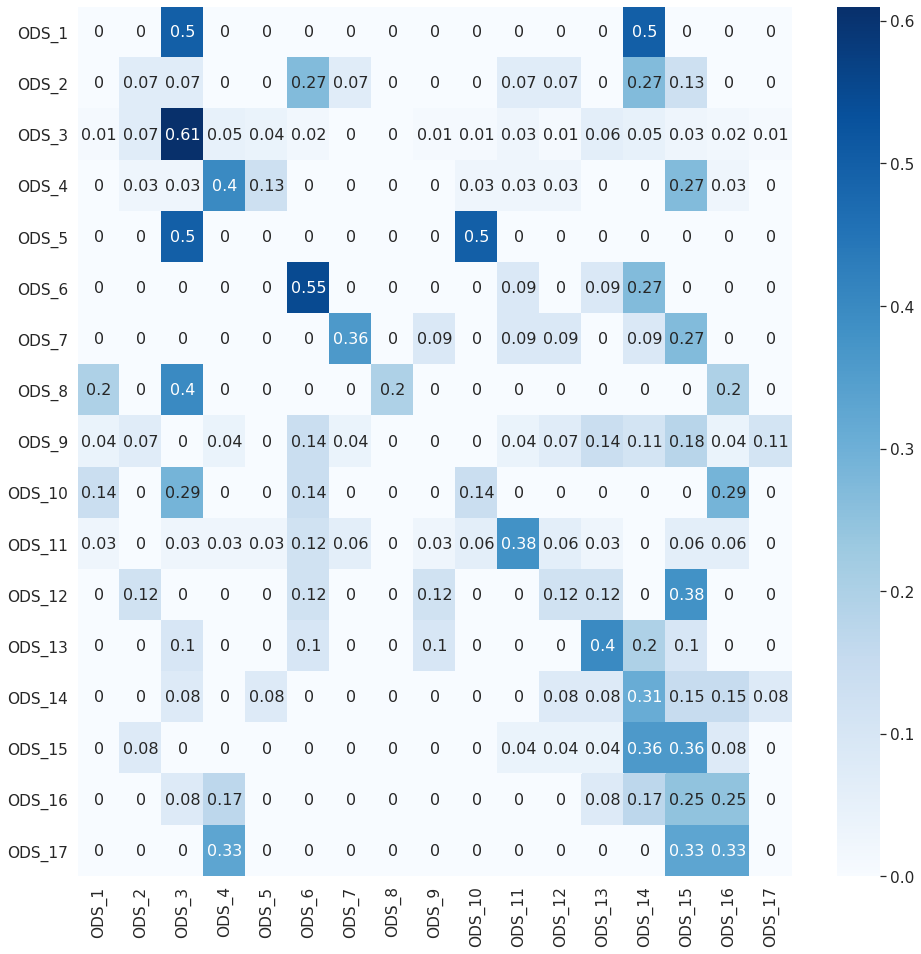

In [ ]:
conf_matrix = confusion_matrix(puc_test["first_sdg"], predictions, labels=range(1, 18), normalize="true")
sdg_index = [f"ODS_{i}" for i in range(1, 18)]
df_cm = pd.DataFrame(conf_matrix, columns=sdg_index, index=sdg_index)
df_cm = df_cm.round(2)
plt.figure(figsize=(16,16))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt="g")
plt.show()

## Train Aurora / Test PUJ

In [ ]:
tokenizer_abstracts = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_abstracts.fit_on_texts(aurora_train["clean_abstract"])

test_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(puj_test["clean_abstract"])
test_padded_abstracts = pad_sequences(test_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
tokenizer_titles = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_titles.fit_on_texts(aurora_train["title"])

test_sequences_titles = tokenizer_titles.texts_to_sequences(puj_test["title"])
test_padded_titles = pad_sequences(test_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
predictions = np.argmax(model.predict([test_padded_abstracts, test_padded_titles]), axis=-1)

In [ ]:
print(classification_report(puj_test["first_sdg"], predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.22      0.25      0.24         8
           3       0.76      0.43      0.55        86
           4       0.29      0.67      0.40         3
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         0
          15       0.08      0.50      0.13         2
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         3

    accuracy                           0.30       140
   macro avg       0.08   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


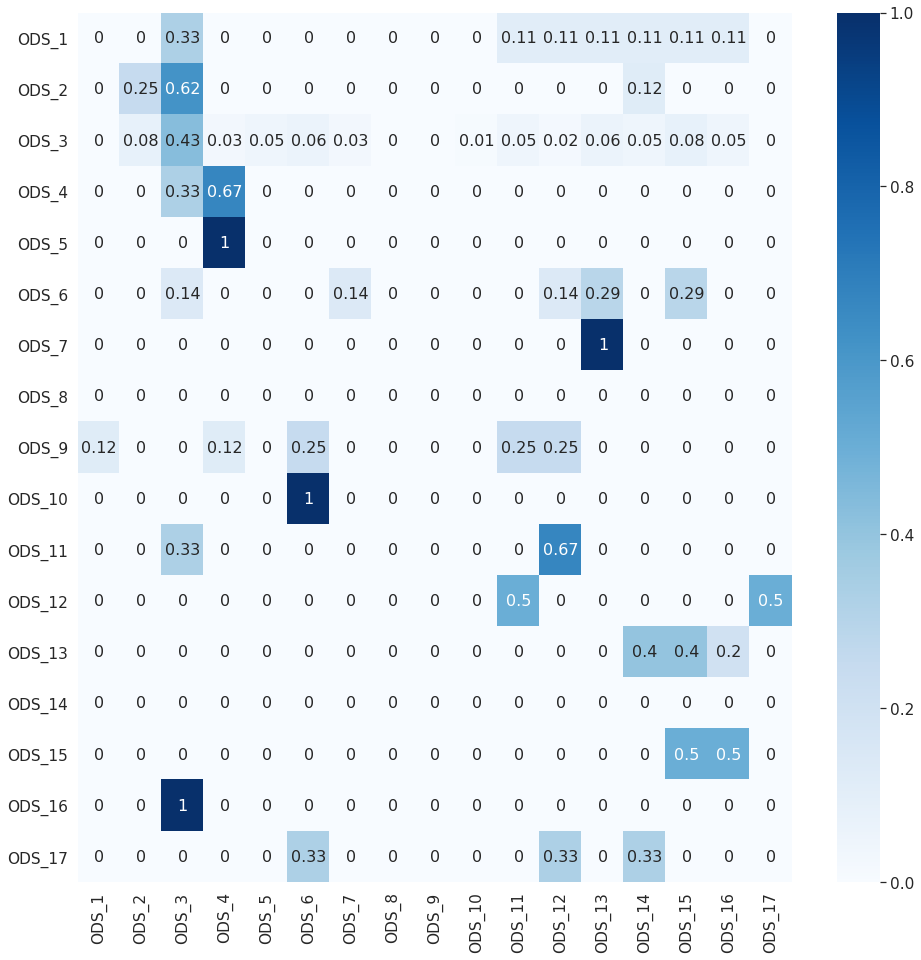

In [ ]:
conf_matrix = confusion_matrix(puj_test["first_sdg"], predictions, labels=range(1, 18), normalize="true")
sdg_index = [f"ODS_{i}" for i in range(1, 18)]
df_cm = pd.DataFrame(conf_matrix, columns=sdg_index, index=sdg_index)
df_cm = df_cm.round(2)
plt.figure(figsize=(16,16))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt="g")
plt.show()

## Train Aurora, PUC, PUJ / Test Aurora, PUC, PUJ

In [ ]:
train = pd.concat([aurora_train, puc_train, puj_train], ignore_index=True)
test = pd.concat([aurora_test, puc_test, puj_test], ignore_index=True)

In [ ]:
len(train)

5489

In [ ]:
tokenizer_abstracts = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_abstracts.fit_on_texts(train["clean_abstract"])

train_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(train["clean_abstract"])
train_padded_abstracts = pad_sequences(train_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences_abstracts = tokenizer_abstracts.texts_to_sequences(test["clean_abstract"])
test_padded_abstracts = pad_sequences(test_sequences_abstracts, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
tokenizer_titles = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_titles.fit_on_texts(train["title"])

train_sequences_titles = tokenizer_titles.texts_to_sequences(train["title"])
train_padded_titles = pad_sequences(train_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences_titles = tokenizer_titles.texts_to_sequences(test["title"])
test_padded_titles = pad_sequences(test_sequences_titles, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
abstracts_input = tf.keras.layers.Input(shape=[max_length])
x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(abstracts_input)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))(x)
x = tf.keras.Model(inputs=abstracts_input, outputs=x)

In [ ]:
titles_input = tf.keras.layers.Input(shape=[max_length])
y = tf.keras.layers.Embedding(vocab_size, embedding_dim)(titles_input)
y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))(y)
y = tf.keras.Model(inputs=titles_input, outputs=y)

In [ ]:
combined = tf.keras.layers.concatenate([x.output, y.output])

In [ ]:
z = tf.keras.layers.Dense(embedding_dim, activation='relu')(combined)
z = tf.keras.layers.Dense(18, activation='softmax')(z)

In [ ]:
model = tf.keras.Model(inputs=[x.input, y.input], outputs=z)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit([train_padded_abstracts, train_padded_titles], train["first_sdg"], epochs=num_epochs, validation_data=([test_padded_abstracts, test_padded_titles], test["first_sdg"]), verbose=1)

Epoch 1/10
172/172 [==============================] - 86s 503ms/step - loss: 2.0183 - accuracy: 0.3979 - val_loss: 1.7725 - val_accuracy: 0.4744
Epoch 2/10
172/172 [==============================] - 85s 494ms/step - loss: 1.2435 - accuracy: 0.6143 - val_loss: 1.5539 - val_accuracy: 0.5290
Epoch 3/10
172/172 [==============================] - 85s 494ms/step - loss: 0.6238 - accuracy: 0.8025 - val_loss: 2.0043 - val_accuracy: 0.5354
Epoch 4/10
172/172 [==============================] - 85s 493ms/step - loss: 0.2441 - accuracy: 0.9242 - val_loss: 2.2580 - val_accuracy: 0.4906
Epoch 5/10
172/172 [==============================] - 85s 493ms/step - loss: 0.1016 - accuracy: 0.9696 - val_loss: 2.7445 - val_accuracy: 0.5247
Epoch 6/10
172/172 [==============================] - 85s 492ms/step - loss: 0.0481 - accuracy: 0.9865 - val_loss: 2.9545 - val_accuracy: 0.5098
Epoch 7/10
172/172 [==============================] - 85s 492ms/step - loss: 0.0297 - accuracy: 0.9923 - val_loss: 3.2171 - val_ac

In [ ]:
predictions = np.argmax(model.predict([test_padded_abstracts, test_padded_titles]), axis=-1)

In [ ]:
print(classification_report(test["first_sdg"], predictions))

              precision    recall  f1-score   support

           1       0.07      0.08      0.07        13
           2       0.15      0.14      0.14        71
           3       0.74      0.86      0.80       771
           4       0.66      0.73      0.69       201
           5       0.53      0.52      0.52       122
           6       0.51      0.49      0.50        91
           7       0.50      0.48      0.49       109
           8       0.16      0.22      0.18        32
           9       0.21      0.15      0.17       136
          10       0.29      0.23      0.25        79
          11       0.47      0.42      0.44       137
          12       0.30      0.27      0.29       106
          13       0.32      0.22      0.26       116
          14       0.43      0.22      0.29        59
          15       0.45      0.47      0.46       149
          16       0.55      0.31      0.40       109
          17       0.13      0.22      0.16        45

    accuracy              

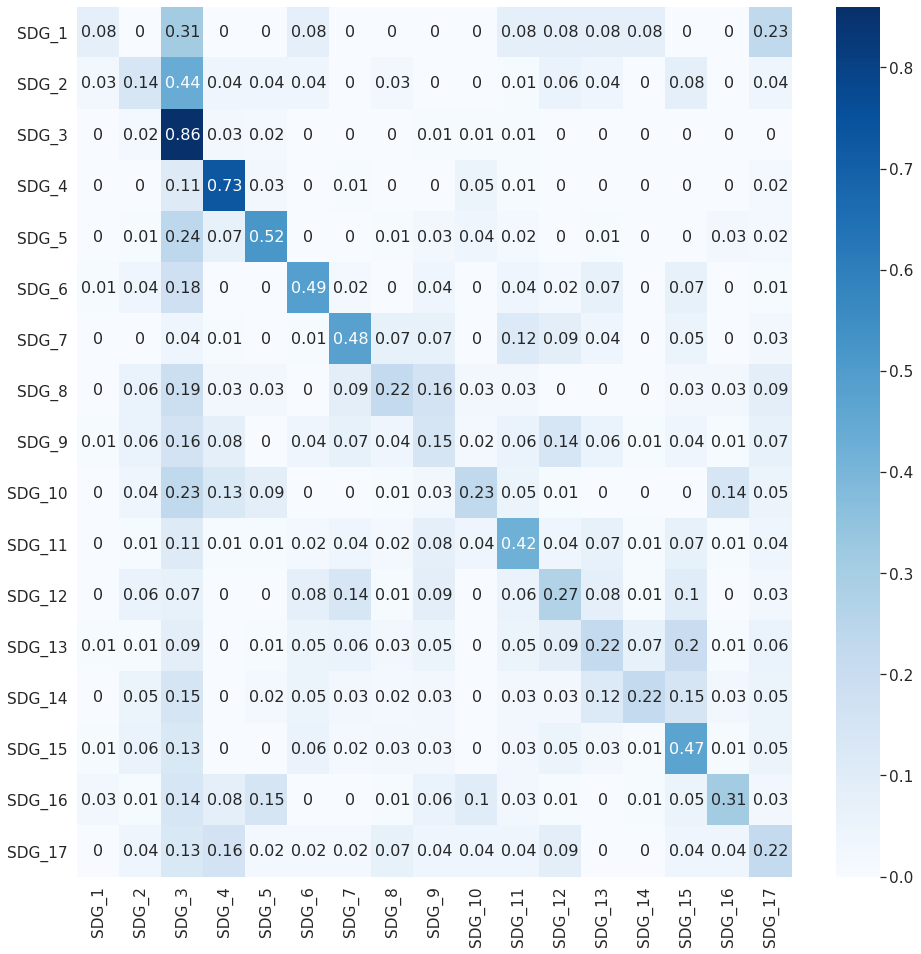

In [ ]:
conf_matrix = confusion_matrix(test["first_sdg"], predictions, labels=range(1, 18), normalize="true")
sdg_index = [f"SDG_{i}" for i in range(1, 18)]
df_cm = pd.DataFrame(conf_matrix, columns=sdg_index, index=sdg_index)
df_cm = df_cm.round(2)
plt.figure(figsize=(16,16))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt="g")
plt.show()